# Cleaning and EDA

In this project we are looking at the titles and comments from r/SteamDeck and r/linux_gaming. In this notebook we will be exploring the datasets and seeing what information can be gleamed, along with some potential minor cleaning along the way. 

### Imports and configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

# Color theme stuff
import mplcatppuccin
from mplcatppuccin.colormaps import get_colormap_from_list
from mplcatppuccin.palette import load_color

from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Allowing more text from the Title and Comments to be shown.
pd.options.display.max_colwidth = 600

In [3]:
# This line is for our plot color schemes down the line.
mpl.style.use("mocha")

In [4]:
# Grabbing the Title data and storing it in a dataframe
titles = pd.read_csv('../data/linux_gaming_SteamDeck_merged_title_data.csv')

# Grabbing the Comment data and storing it in a dataframe
comments = pd.read_csv('../data/linux_gaming_SteamDeck_merged_comment_data.csv')

In [5]:
titles.head()

,title_id,title,subreddit
0,pu1k55,Epic Games announce full Easy Anti-Cheat for Linux including Wine & Proton,linux_gaming
1,9pkgwj,The struggles of being a modern age Linux gamer.,linux_gaming
2,q8trki,"Steam has banned all games that utilise blockchain tech, NFTs, or cryptocurrencies from the platform",linux_gaming
3,ijat04,They didn't expect Linux gaming in 2007,linux_gaming
4,re13t3,LTT Are Planning to Include Linux Compatibility in Future Hardware Reviews,linux_gaming


In [6]:
comments.head()

,comment_id,comments,subreddit
0,jibfcl5,Fun fact: The Steam Deck logo is just a pokeball that isn’t trying. \n\nSecond fun fact: Everyone else here is wrong. I’m right. \n\nThird fun fact: Human blood works as an industrial lubricant.,SteamDeck
1,jib4baj,"No it's not. The ""logo"" you see on the memory maker is coming from the old camera knob. They where used to crank the camera for to record. The clip could be pulled up, then turned and put back in. \n\n[Vintage camera](https://thumbs.dreamstime.com/z/vintage-super-eight-film-camera-white-background-66847894.jpg)\n\nEdit\n\nThe logo of steam comes from a vintage ""steam machine"" and the steam deck is a flywheel part that's also used in steam machines. \n\n[Steam machine drive](https://i.ytimg.com/vi/ghsCY8U_O_0/maxresdefault.jpg) look at the wheel center part.\n\nEdit 2\n\nMy bad, wrong desc...",SteamDeck
2,jibacht,Glad this isn't getting the traction you hoped for,SteamDeck
3,jib5m0m,Can't tell if you actually thought it was,SteamDeck
4,jib5qio,“This was inspired by this because it looks like it.” Come on guys not everything has to have a reference or a nod.,SteamDeck


Let's look at how much data we have. 

In [7]:
print(titles.shape)

print(comments.shape)

(6305, 3)
(495846, 3)


In [8]:
print(titles['subreddit'].value_counts())
print('-'*30)
print(comments['subreddit'].value_counts())

SteamDeck       4012
linux_gaming    2293
Name: subreddit, dtype: int64
------------------------------
SteamDeck       326472
linux_gaming    169374
Name: subreddit, dtype: int64


In [9]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6305 entries, 0 to 6304
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title_id   6305 non-null   object
 1   title      6305 non-null   object
 2   subreddit  6305 non-null   object
dtypes: object(3)
memory usage: 147.9+ KB


In [10]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495846 entries, 0 to 495845
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   comment_id  495846 non-null  object
 1   comments    495842 non-null  object
 2   subreddit   495846 non-null  object
dtypes: object(3)
memory usage: 11.3+ MB


### Imbalanced Data
As we can see above, we have a pretty imbalanced set of data, with the majority of our data being from r/SteamDeck, by it representing close to 2/3 of our dataset. This is because the data has been pulled regularly from the Reddit API which limits the amount of posts that can be collected to the the first 1000 posts in the respective category. Gathering data over time by repeatedly hitting the api and dropping duplicates will lead to the more popular and active subreddit getting more data than the other.

Because of this imbalance of data, we will have to be more aware of our various results in through out this study. 

---

## Looking at lengths
We have a good amount of titles and comments. Let's add length and word count column to get an idea of the individual sizes of the titles and comments. We can then later examine them to help us find patterns between our 2 different subreddits, and to help us spot things that should be cleaned or taken note of for later work. 

In [11]:
# Forcing all the values in these columns to be read as Strings.
# There are instances where a title or comment may just contain numbers,
# so we much make sure ALL values are read as a string
titles['title'] = titles['title'].astype(str)
comments['comments'] = comments['comments'].astype(str)

In [12]:
# Adding a column for length and word count to both the title set and the comment set.
titles['title_length'] = [len(title) for title in titles['title']]
titles['title_word_count'] = [len(title.split()) for title in titles['title']]

comments['comment_length'] = [len(comment) for comment in comments['comments']]
comments['comment_word_count'] = [len(comment.split()) for comment in comments['comments']]

In [13]:
titles.head()

,title_id,title,subreddit,title_length,title_word_count
0,pu1k55,Epic Games announce full Easy Anti-Cheat for Linux including Wine & Proton,linux_gaming,74,12
1,9pkgwj,The struggles of being a modern age Linux gamer.,linux_gaming,48,9
2,q8trki,"Steam has banned all games that utilise blockchain tech, NFTs, or cryptocurrencies from the platform",linux_gaming,100,15
3,ijat04,They didn't expect Linux gaming in 2007,linux_gaming,39,7
4,re13t3,LTT Are Planning to Include Linux Compatibility in Future Hardware Reviews,linux_gaming,74,11


In [14]:
comments.head()

,comment_id,comments,subreddit,comment_length,comment_word_count
0,jibfcl5,Fun fact: The Steam Deck logo is just a pokeball that isn’t trying. \n\nSecond fun fact: Everyone else here is wrong. I’m right. \n\nThird fun fact: Human blood works as an industrial lubricant.,SteamDeck,190,33
1,jib4baj,"No it's not. The ""logo"" you see on the memory maker is coming from the old camera knob. They where used to crank the camera for to record. The clip could be pulled up, then turned and put back in. \n\n[Vintage camera](https://thumbs.dreamstime.com/z/vintage-super-eight-film-camera-white-background-66847894.jpg)\n\nEdit\n\nThe logo of steam comes from a vintage ""steam machine"" and the steam deck is a flywheel part that's also used in steam machines. \n\n[Steam machine drive](https://i.ytimg.com/vi/ghsCY8U_O_0/maxresdefault.jpg) look at the wheel center part.\n\nEdit 2\n\nMy bad, wrong desc...",SteamDeck,635,90
2,jibacht,Glad this isn't getting the traction you hoped for,SteamDeck,50,9
3,jib5m0m,Can't tell if you actually thought it was,SteamDeck,41,8
4,jib5qio,“This was inspired by this because it looks like it.” Come on guys not everything has to have a reference or a nod.,SteamDeck,115,23


Let's see what the **shortest** and **longest** titles and comments look like.

In [15]:
titles.sort_values(by='title_word_count', ascending=True).head(20)

,title_id,title,subreddit,title_length,title_word_count
4662,12w6h1m,Help!!!,SteamDeck,7,1
3766,zj5uaz,Announcements,SteamDeck,13,1
2337,133z703,Chiaki4Deck,SteamDeck,11,1
3140,1305uln,Help,SteamDeck,4,1
6045,12qn4q9,gta5,SteamDeck,4,1
3150,130f2z0,Question,SteamDeck,8,1
6165,12q5gdn,Repair,SteamDeck,6,1
5708,12sgpts,Help,SteamDeck,4,1
3471,wbui46,🥲,SteamDeck,1,1
2407,133za5c,Officedeck,SteamDeck,10,1


In [16]:
titles.sort_values(by='title_word_count', ascending=False).head(20)

,title_id,title,subreddit,title_length,title_word_count
3073,12zxrci,Has anyone tried one of these stations with their Deck? I've been using a third party dock for a while (with my Deck mostly in desktop mode as a PC) and I got the Dbrand case which made it too bulky for the dock. I was thinking about one of these stations so I could leave the grip on at all times.,SteamDeck,298,62
4897,12uzwuo,Does An SSD make that much of a difference in games running on deck ?. im gonna be daily driving it for a couple weeks while my PC is in the shop. I assume maybe load times are like 10-15% better but for like 50% of the price extra idk doesnt seem worth it for deck with how low performance it is,SteamDeck,296,62
5908,12rrksu,"Does anyone know how to access the yellow bar and find out what it is? Seems like every time I download a game it gets bigger. If it keeps up I’m gonna run out of space, every game I’ve downloaded is on my SD card. Thought it was the protons but they are listed as games or the blue bar…",SteamDeck,287,60
6240,12vmsuh,Darn good first attempt at applying a skin cover. I found its best when working the last bits to be gentle with pushing the rest down; don't try to FORCE the bend to go where you want or it'll crease. Just heat and work little bits at a time. Kinda bummed there isn't a red and blue back as well.,SteamDeck,296,60
3374,x0j4dk,"I'm back with a new guide. This time, I worked on a complete starter guide for all first-time Steam Deck users. I've tried my best to cover all the basics and help you get going the moment you get your Deck. I plan to regularly update the post, so if I missed something, I'll get back to writing.",SteamDeck,296,58
4138,tm3526,Working on a 3D printable battery pack for the Deck you can easily clip on the back for an extra 10000mAh. The battery pack itself got its own bottom charging port. the USB C cable comes out the top and simply connects to the deck. Including an easy to use 4 digit battery pack status led stripe.,SteamDeck,296,57
705,ul7blo,"Hey, I'm making a collection of typical Linux VR problems. If you play VR on Linux too, please send me problems with solutions you had back when you started. I will write them down to make life easier for everyone. If you have no problems for me, you could read it and give me feedback, thanks. :)",linux_gaming,297,57
5914,12re9sc,"I wanted to use it to play Guilty Gear strive modded, I did do it manually once but Unverum helps organize it, there was another post of someone who had trouble running unverum but I need more fleshed out steps on what to do, for example when I try opening the application it asks me this",SteamDeck,288,56
4152,ysk7kc,"As someone who started playing handheld games back when the Game Boy Color was new, watching mobile technology evolve has been wild. The Game Boy Advance was one of my favorite consoles of all time, so I thought it would be fun to compare some GBA games to screenshots I’ve taken on my Steam Deck.",SteamDeck,297,55
2920,131hag1,"SteamDeck EmuDeck update SNAFU: I added way too many roms with the parser, tried to stop it half way through, and it did, but now I got a huge pile of uncategorized/non-steam games that I can't delete except one at a time. Is there a file I can clear? The Emudeck remove list isn't working.",SteamDeck,290,55


Looking at shortest titles we can immediately notice some potential issues for later. 
* Combining words with symbols like `/`, `-`, `_`
* Words with LEET speak
* Acronyms

In [17]:
comments.sort_values(by='comment_word_count', ascending=True).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
241483,hz421cf,¿que?,SteamDeck,5,1
263477,ibldgs7,https://www.polygon.com/deals/22938610/steam-deck-best-sd-card-micro-storage-price-speed,SteamDeck,88,1
180158,iodv0tz,[deleted],SteamDeck,9,1
383826,hzjzv03,:(,linux_gaming,2,1
470385,dajip85,[deleted],linux_gaming,9,1
470380,dajn37l,[deleted],linux_gaming,9,1
383840,hzki6y7,[deleted],linux_gaming,9,1
263414,ibn25xj,Label*,SteamDeck,6,1
383846,hzib7m2,[deleted],linux_gaming,9,1
470364,dajpoxk,[deleted],linux_gaming,9,1


In [18]:
comments.sort_values(by='comment_word_count', ascending=False).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
487906,f9tocpc,"> You're right they're not, I got a 3900x CPU and they are running 9900k's, you know, a faster CPU for most games, not outrunning my 1080ti, dude please stop lol.\n\nYeah dude...This is what I mean by stop using Windows numbers when you're thinking about parts under Linux: Those extra cores on your 3900X versus that 9900k are almost certainly helping DXVK shader compilation which is one of the biggest performance hitting areas when running Linux. That was literally my point with the 3570k vs 3770k. (A somewhat slower GPU on Windows can end up *much* faster without the type of CPU bottlenec...",linux_gaming,9980,1760
152888,in32c1w,"1. I've had equipment thrown at me.\n2. I've had a customer get angry at me personally because I told them that the expensive iPhone they bought abroad was actually a fake running an iOS skin on Android, and they thought I was lying to them.\n3. I've been admonished for an Xbox One falling onto the floor because the wooden shelf unit of the till I was working was on collapsed, because ""It didn't happen to other people"". The problem with the shelf unit had been repeatedly pointed out and it wasn't fixed until the incident above. We had to buy the Xbox One in, then ship it off to be looked a...",SteamDeck,9143,1669
367882,fxdbcgh,"Dude, you have like an 8th-grade level understanding of what Capitalism is, how it works, and economics in general. You're legitimately not worth the time and it's not my job to educate you out of your ignorance. But I'll go ahead and briefly try and touch on all the nonsense. \n\n\n>If the price of me having ability to earn and purchase enough for a comfortable house and retirement life is some guy getting another 0 on estimation of his company's capitalization (which is most of the so-called billionaires), i would take that deal any day of the year.\n\nThat has literally nothing whatsoev...",linux_gaming,9948,1633
454961,fw7ydbj,"Not all competition is good or useful competition. For example, how much has digital distribution improved as a result of uPlay or Origin after all these years? Not very much, if at all...Hell, it's viewed as a good thing that EA has finally gone back to selling games on Steam which tells you everything. Valve certainly has its flaws, but I'm not exactly clamouring for a new name in it, particularly one that makes their initial appearance with a client severely lacking in features but with some games that you want because they paid for exclusivity...That's not something I personally view a...",linux_gaming,8953,1566
437103,fpc9iuh,">It's 2020. Not 2009.\n\n>A lot has changed since 2009, that's over a decade ago.\n\nYup, it sure has. Linux has grown far more than OS X in terms of polish over the last 11 years given the fact that we all were still using Gnome2 and not really able to play much in the way of games on Linux back then, although to be fair OS X was already far more polished than Linux was in 2009 and still is quite far ahead in that regard today, but either way, you're missing the point still: Ask 10 different reliable sources of OS usage statistics data for their stats and you'll wind up with 10 different ...",linux_gaming,8920,1521
378053,fqwe7gn,">We are in a linux gaming sub. The whole point is to evaluate GPU issues here and talk about Linux games.\n\nWe are in a linux gaming sub. This sub caters to a number of different demographics who each seek different things in this sub.\n\nYou've got not really technical linux gamers. Those are gonna seek reviews on how well some games work on linux, technical advice from more knowledgeable members, they'll often post questions to get advice for specific issues they're encountering.\n\nAmong those issues, GPU choice is one of them and the answer to that isn't black and white. For a long ti...",linux_gaming,8606,1519
307463,j4st6ca,"> You're basically admitting here that you've had prior experience on the mouse\

Now looking at the shortest comment data shows us something else that will be problematic, posts that have been deleted. This one is easy to fix. We can simply drop observations labeled `[deleted]` and `[removed]`. We won't need to do this for the Title's dataset because deleted posts don't get pulled by the api.

In [19]:
comments.drop(comments[comments['comments'] == '[deleted]'].index, inplace=True)
comments.drop(comments[comments['comments'] == '[removed]'].index, inplace=True)

In [20]:
comments.sort_values(by='comment_word_count', ascending=True).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
390165,g9hdk4g,TLDR?,linux_gaming,5,1
57857,j7wt7au,Yesss!!,SteamDeck,7,1
267741,iooy1x7,Happiness...,SteamDeck,12,1
207802,ij4tctm,Congratulations!,SteamDeck,16,1
147931,isuqayo,Same,SteamDeck,4,1
345219,hdzzd0k,https://twitter.com/timsweeneyepic/status/964284402741149698,linux_gaming,60,1
258037,ivhsx9w,Oh.,SteamDeck,3,1
236316,j77c932,🤡,SteamDeck,1,1
110479,ictbvpj,No.,SteamDeck,3,1
75584,iyk2odu,Agreed,SteamDeck,6,1


In [21]:
comments.shape

(486073, 5)

## Prepocessing

Now let's preproccess our data to get rid of all the stuff we don't want. We just want alpanumeric characters, so we'll strip out everything else. We do this now so that we don't run into issues later when we start splitting our data frames. It is import to note now though that the **Word Count** and **Length Commmets** do not get changed. This means those columns are of the original length and word count, and not the current length after preproccessing our data.

In [22]:
def my_preprocessor(text):
    text = text.lower()
    text = re.sub('\\n', '', text)
    text = re.findall("[\w']+|\$[\d\.]+", text)
    text = ' '.join(text)
    
    return text

In [23]:
titles['title'] = [my_preprocessor(title) for title in titles['title']]
comments['comments'] = [my_preprocessor(comment) for comment in comments['comments']]

In [24]:
comments.sort_values(by='comment_word_count', ascending=True).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
390165,g9hdk4g,tldr,linux_gaming,5,1
57857,j7wt7au,yesss,SteamDeck,7,1
267741,iooy1x7,happiness,SteamDeck,12,1
207802,ij4tctm,congratulations,SteamDeck,16,1
147931,isuqayo,same,SteamDeck,4,1
345219,hdzzd0k,https twitter com timsweeneyepic status 964284402741149698,linux_gaming,60,1
258037,ivhsx9w,oh,SteamDeck,3,1
236316,j77c932,,SteamDeck,1,1
110479,ictbvpj,no,SteamDeck,3,1
75584,iyk2odu,agreed,SteamDeck,6,1


In [25]:
comments.sort_values(by='comment_word_count', ascending=False).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
487906,f9tocpc,you're right they're not i got a 3900x cpu and they are running 9900k's you know a faster cpu for most games not outrunning my 1080ti dude please stop lol yeah dude this is what i mean by stop using windows numbers when you're thinking about parts under linux those extra cores on your 3900x versus that 9900k are almost certainly helping dxvk shader compilation which is one of the biggest performance hitting areas when running linux that was literally my point with the 3570k vs 3770k a somewhat slower gpu on windows can end up much faster without the type of cpu bottleneck a windows user wo...,linux_gaming,9980,1760
152888,in32c1w,1 i've had equipment thrown at me 2 i've had a customer get angry at me personally because i told them that the expensive iphone they bought abroad was actually a fake running an ios skin on android and they thought i was lying to them 3 i've been admonished for an xbox one falling onto the floor because the wooden shelf unit of the till i was working was on collapsed because it didn't happen to other people the problem with the shelf unit had been repeatedly pointed out and it wasn't fixed until the incident above we had to buy the xbox one in then ship it off to be looked at to see if it...,SteamDeck,9143,1669
367882,fxdbcgh,dude you have like an 8th grade level understanding of what capitalism is how it works and economics in general you're legitimately not worth the time and it's not my job to educate you out of your ignorance but i'll go ahead and briefly try and touch on all the nonsense if the price of me having ability to earn and purchase enough for a comfortable house and retirement life is some guy getting another 0 on estimation of his company's capitalization which is most of the so called billionaires i would take that deal any day of the year that has literally nothing whatsoever to do with econom...,linux_gaming,9948,1633
454961,fw7ydbj,not all competition is good or useful competition for example how much has digital distribution improved as a result of uplay or origin after all these years not very much if at all hell it's viewed as a good thing that ea has finally gone back to selling games on steam which tells you everything valve certainly has its flaws but i'm not exactly clamouring for a new name in it particularly one that makes their initial appearance with a client severely lacking in features but with some games that you want because they paid for exclusivity that's not something i personally view as improving ...,linux_gaming,8953,1566
437103,fpc9iuh,it's 2020 not 2009 a lot has changed since 2009 that's over a decade ago yup it sure has linux has grown far more than os x in terms of polish over the last 11 years given the fact that we all were still using gnome2 and not really able to play much in the way of games on linux back then although to be fair os x was already far more polished than linux was in 2009 and still is quite far ahead in that regard today but either way you're missing the point still ask 10 different reliable sources of os usage statistics data for their stats and you'll wind up with 10 different sets of numbers th...,linux_gaming,8920,1521
378053,fqwe7gn,we are in a linux gaming sub the whole point is to evaluate gpu issues here and talk about linux games we are in a linux gaming sub this sub caters to a number of different demographics who each seek different things in this sub you've got not really technical linux gamers those are gonna seek reviews on how well some games work on linux technical advice from more knowledgeable members they'll often post questions to get advice for specific issues they're encountering among those issues gpu choice is one of them and the answer to that isn't black and white for a long time even though close...,linux_gaming,8606,1519
307463,j4st6ca,you're basically admitting here that you've had prior experience on the mouse who doesn't they'

In [26]:
# The new empty comments aren't being treated as nulls
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486073 entries, 0 to 495845
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   comment_id          486073 non-null  object
 1   comments            486073 non-null  object
 2   subreddit           486073 non-null  object
 3   comment_length      486073 non-null  int64 
 4   comment_word_count  486073 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 22.3+ MB


In [27]:
# Let's drop the empty comments since they provide on value.
comments.drop(comments[comments['comments']==''].index, inplace=True)

In [28]:
comments.sort_values(by='comment_word_count', ascending=True).head(20)

,comment_id,comments,subreddit,comment_length,comment_word_count
398527,hggo8t8,fr,linux_gaming,2,1
364041,gn0j3lq,kubuntu,linux_gaming,8,1
201783,j86chrs,r tomorrow,SteamDeck,10,1
241824,ibg8qpj,exactly,SteamDeck,7,1
354314,hgdeolc,huehuehue,linux_gaming,9,1
332940,jgw95gi,ok,linux_gaming,2,1
51656,invxlly,dayman,SteamDeck,7,1
122951,jahh7ve,topkingchampionwinfast,SteamDeck,22,1
241786,ibfhw7y,drakengard,SteamDeck,10,1
475991,frn9gwa,http babysoftmurderhands com wp content uploads 2013 02 history lets take a look inside the office of doom era id software jpg,linux_gaming,128,1


## Post length distributions

In [29]:
cat_color = ['rosewater', 'flamingo', 'pink', 'mauve', 'red', 'maroon', 'peach',
                 'yellow', 'green', 'teal', 'sky', 'sapphire', 'blue', 'lavender']

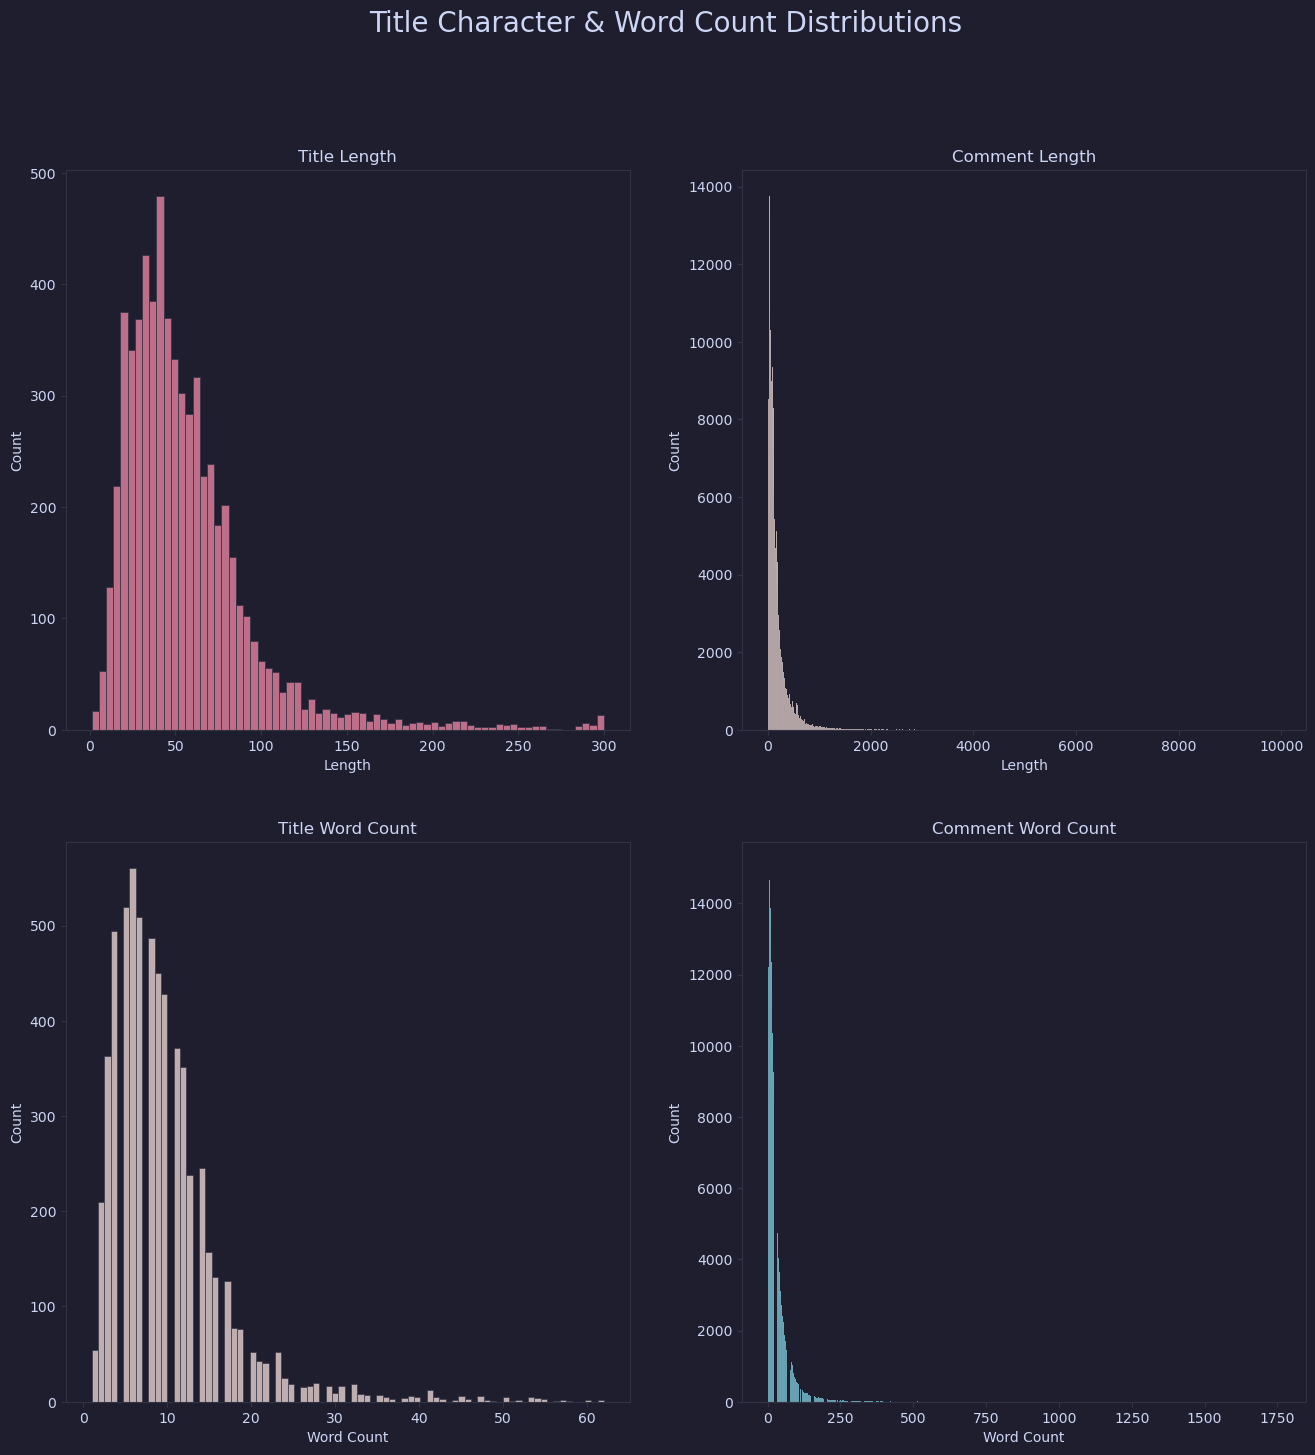

In [30]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))
sns.histplot(titles['title_length'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))
sns.histplot(comments['comment_length'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))
sns.histplot(titles['title_word_count'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))
sns.histplot(comments['comment_word_count'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Length', title='Title Length')
ax[0,1].set(xlabel='Length', title='Comment Length')
ax[1,0].set(xlabel='Word Count', title='Title Word Count')
ax[1,1].set(xlabel='Word Count', title='Comment Word Count')

fig.suptitle('Title Character & Word Count Distributions', fontsize=20);

These visuals don't help us much, because the upper ends are drastically bigger than the rest of each respective data set. Let's first look at how the distributions look, filtered by each subreddit.

In [31]:
### Making Filtered Dataframes

sd_titles = titles[titles['subreddit']=='SteamDeck'] 
sd_comments = comments[comments['subreddit']=='SteamDeck']
lg_titles = titles[titles['subreddit']=='linux_gaming']
lg_comments = comments[comments['subreddit']=='linux_gaming']

### Title Plots

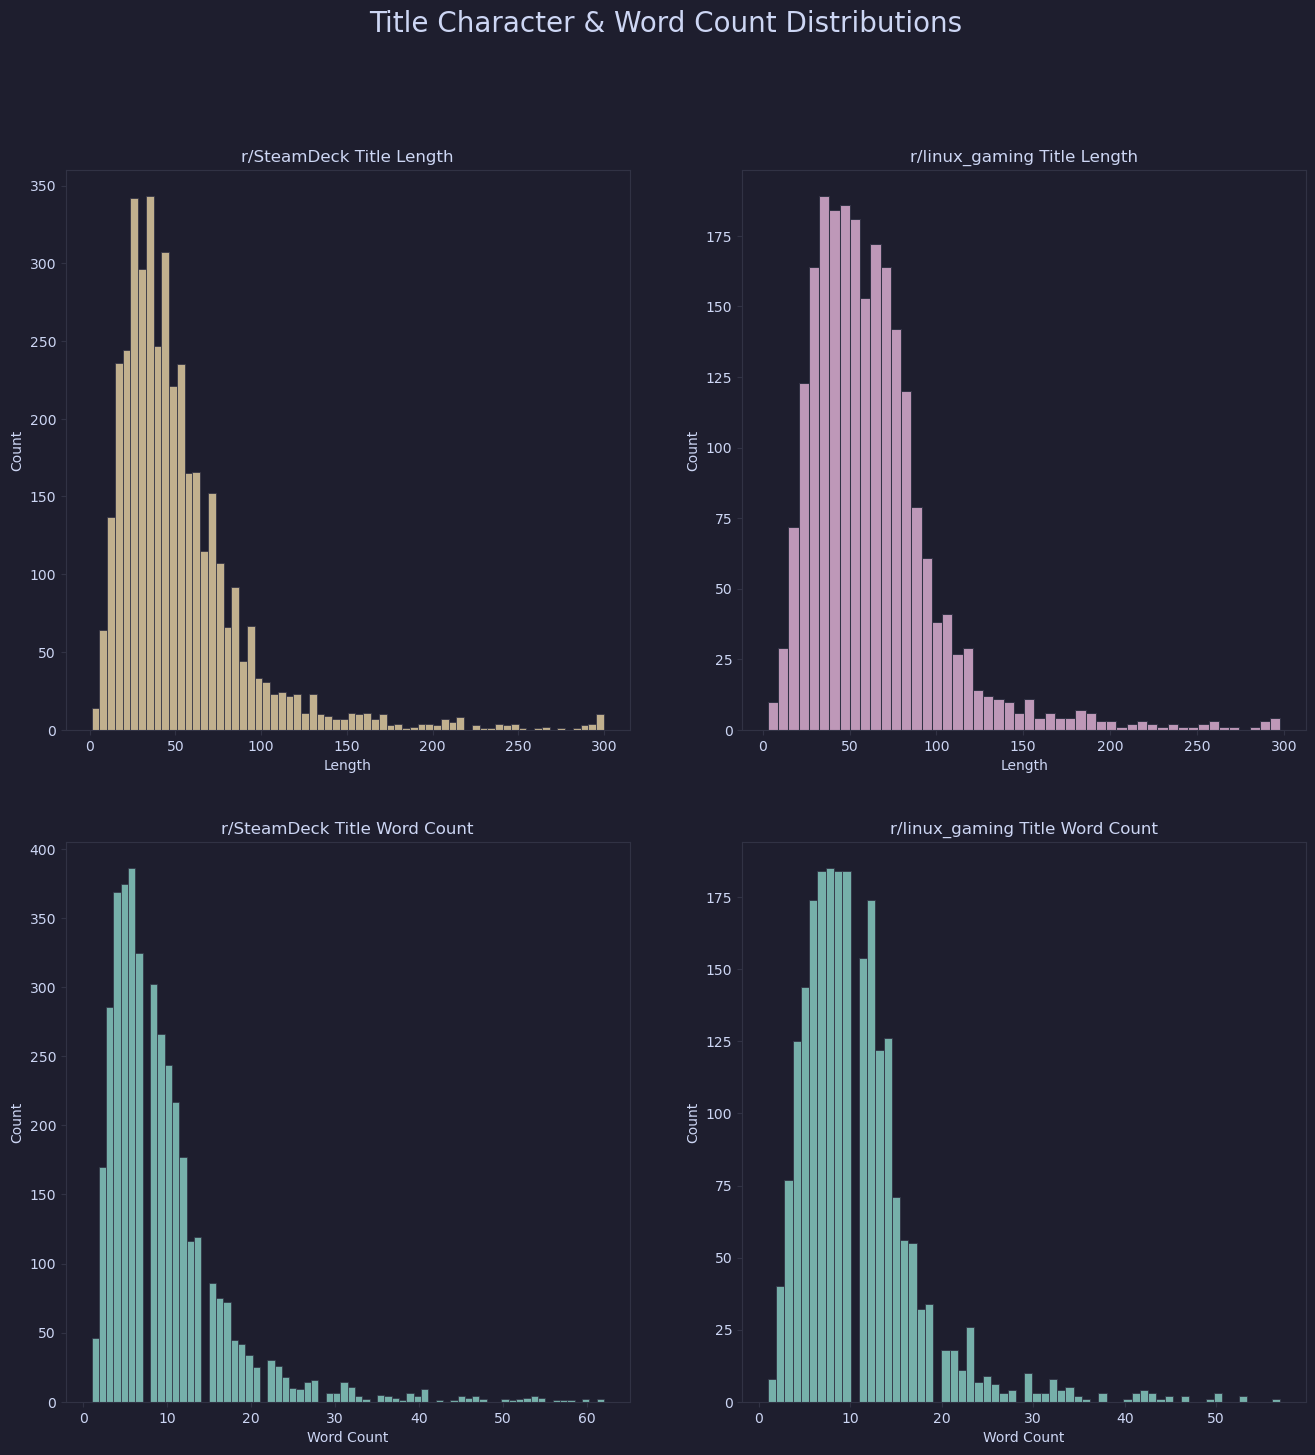

In [32]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

# r/SteamDeck Title's Lengths
sns.histplot(sd_titles['title_length'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

# r/linux_gaming Title's Lengths
sns.histplot(lg_titles['title_length'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

# r/SteamDeck Title's Word Counts
sns.histplot(sd_titles['title_word_count'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

# r/linux_gaming Title's Word Counts
sns.histplot(lg_titles['title_word_count'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Length', title='r/SteamDeck Title Length')
ax[0,1].set(xlabel='Length', title='r/linux_gaming Title Length')
ax[1,0].set(xlabel='Word Count', title='r/SteamDeck Title Word Count')
ax[1,1].set(xlabel='Word Count', title='r/linux_gaming Title Word Count')

fig.suptitle('Title Character & Word Count Distributions', fontsize=20);

It looks like r/linux_gaming is willing to have longer titles on average, but the tail end extremes belong to r/SteamDeck

### Comment Plots

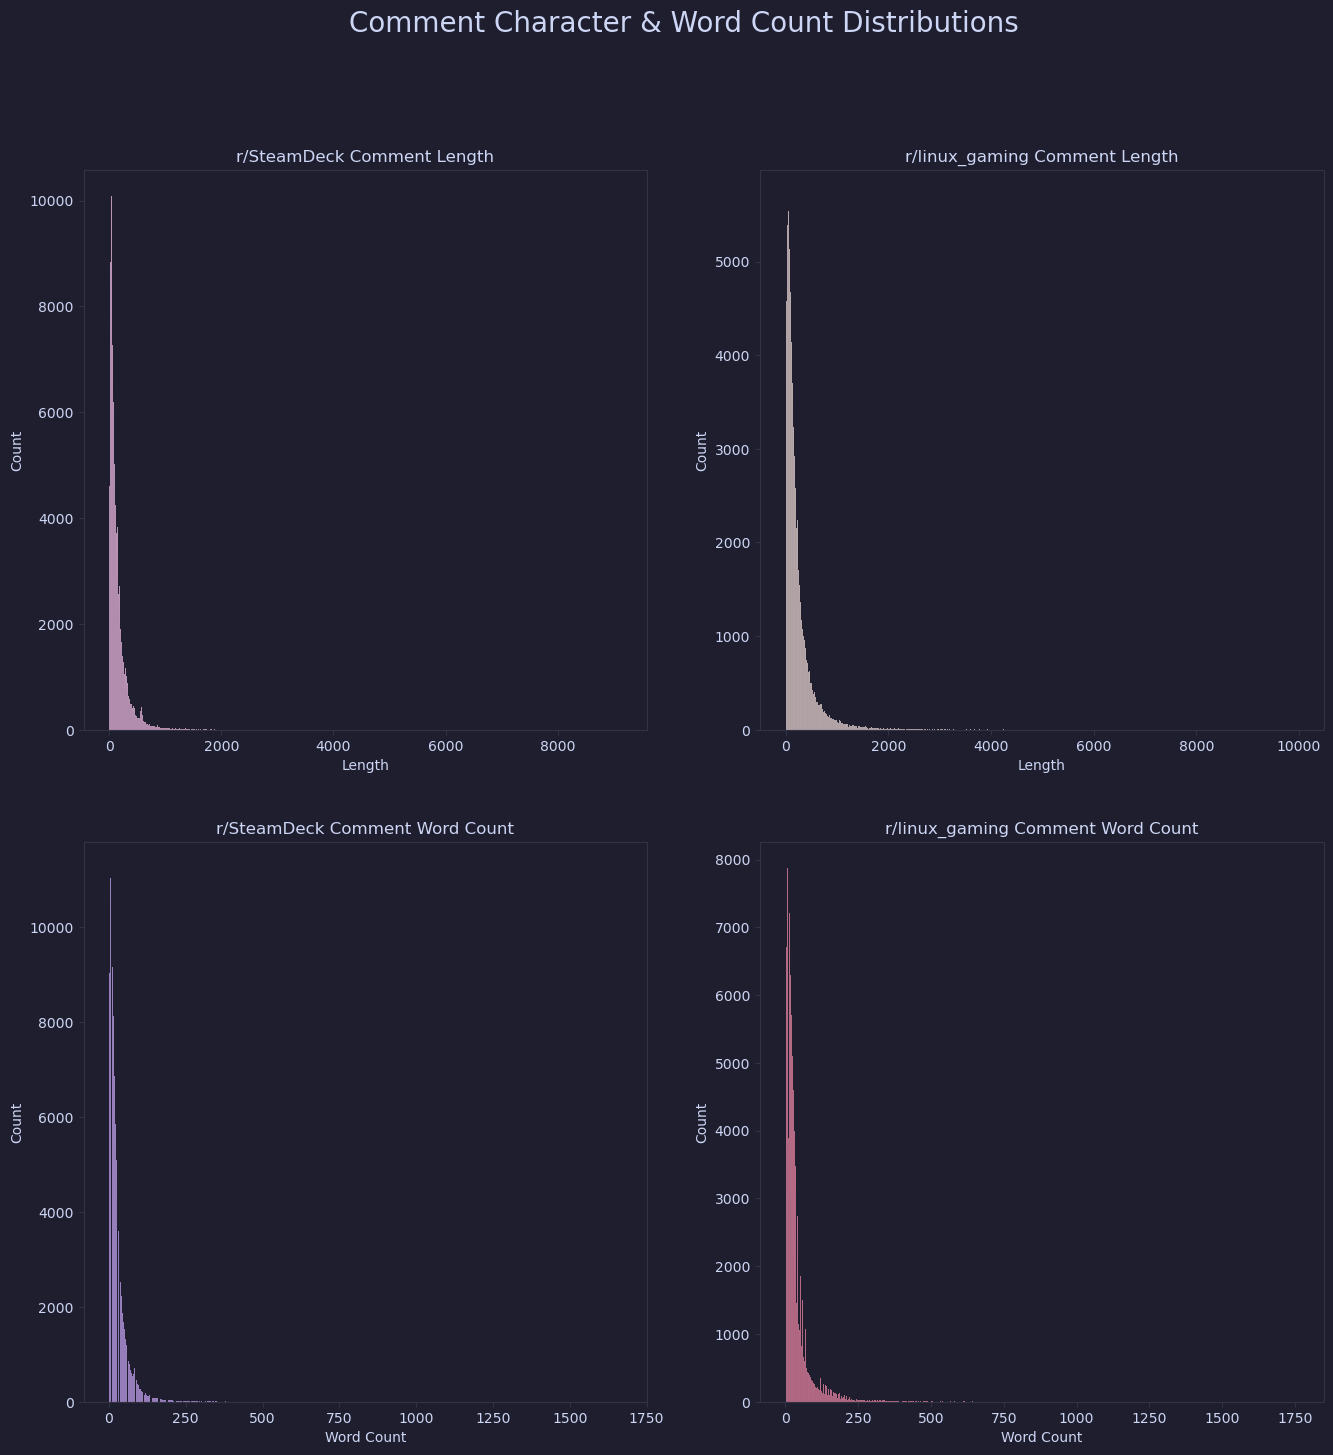

In [33]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

# /SteamDeck Comment's Lengths
sns.histplot(sd_comments['comment_length'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

# /linux_gaming Comment's Lengths
sns.histplot(lg_comments['comment_length'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

# /SteamDeck Comment's Word Counts
sns.histplot(sd_comments['comment_word_count'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

# /linux_gaming Comment's Word Counts
sns.histplot(lg_comments['comment_word_count'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Length', title='r/SteamDeck Comment Length')
ax[0,1].set(xlabel='Length', title='r/linux_gaming Comment Length')
ax[1,0].set(xlabel='Word Count', title='r/SteamDeck Comment Word Count')
ax[1,1].set(xlabel='Word Count', title='r/linux_gaming Comment Word Count')

fig.suptitle('Comment Character & Word Count Distributions', fontsize=20);

Even though r/linux_gaming has less data overall, we are seeeing more representation from it in the longer comments. 

## Recap

### RegEx
When we begin to proccess the data for modeling we should make sure to use RegEx to help us deal with various writing patterns, including:
- Using `/` to alternate different words that can fit in same place of a sentance.
- Using `-` to combine words together
- URLs of various popular websites
- Emojis
- etc

We do this by getting rid of everything other than alphanumeric characters.

### Differences in length
Although the two subreddits have fairly similar distributions, there are some noteworthy differences. r/SteamDeck seems to favor shorter length in titles and r/linux_gaming seems to favor longer comments. 

## Word EDA

We will now vectorize the words in the dataset and do some EDA on the words themselves that appear.

### Top 10 Most Common Words in Titles

In [35]:
cv = CountVectorizer(stop_words='english', max_features=1000)

sd_titles_vect = cv.fit_transform(sd_titles['title'])
sd_titles_vect_df = pd.DataFrame(sd_titles_vect.todense(), columns=cv.get_feature_names_out())

lg_titles_vect = cv.fit_transform(lg_titles['title'])
lg_titles_vect_df = pd.DataFrame(lg_titles_vect.todense(), columns=cv.get_feature_names_out())

sd_comments_vect = cv.fit_transform(sd_comments['comments'])
sd_comments_vect_df = pd.DataFrame(sd_comments_vect.todense(), columns=cv.get_feature_names_out())

lg_comments_vect = cv.fit_transform(lg_comments['comments'])
lg_comments_vect_df = pd.DataFrame(lg_comments_vect.todense(), columns=cv.get_feature_names_out())

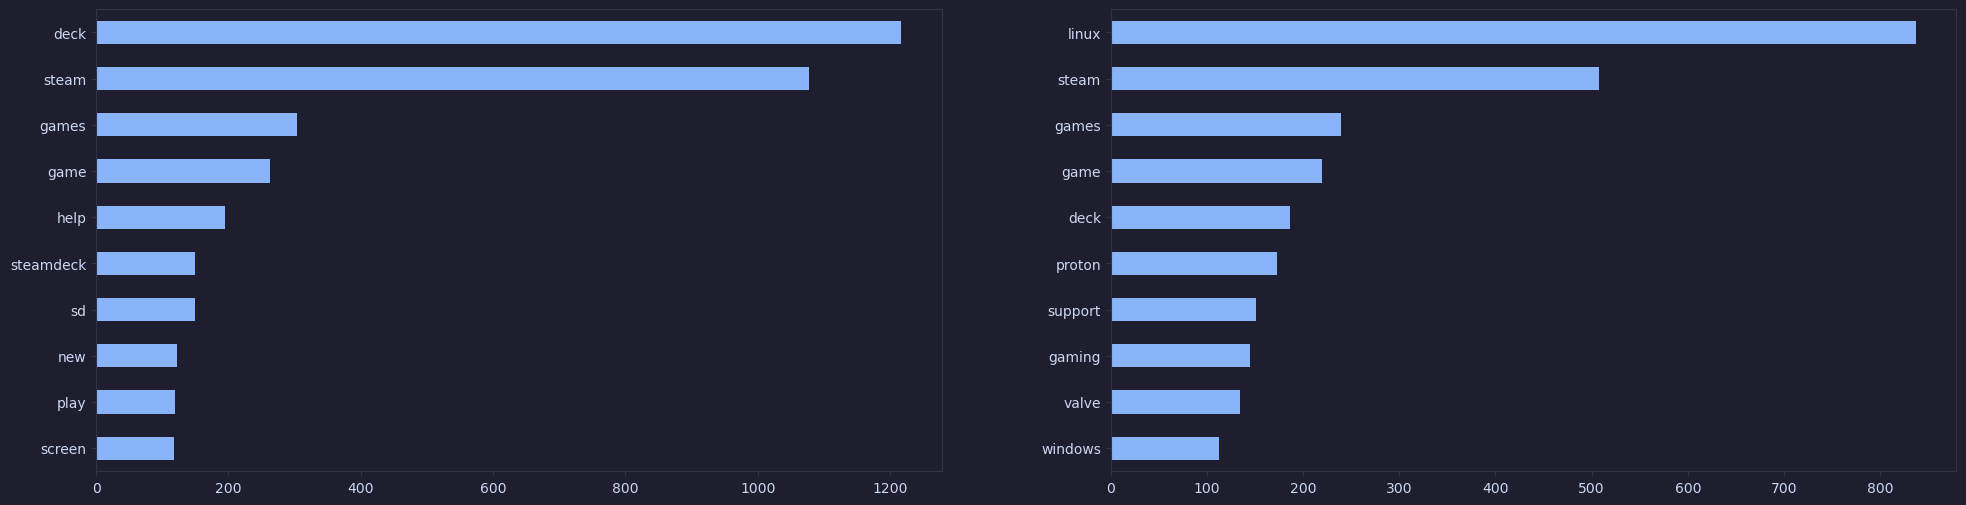

In [36]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

### Top 10 Most Common Words in Comments

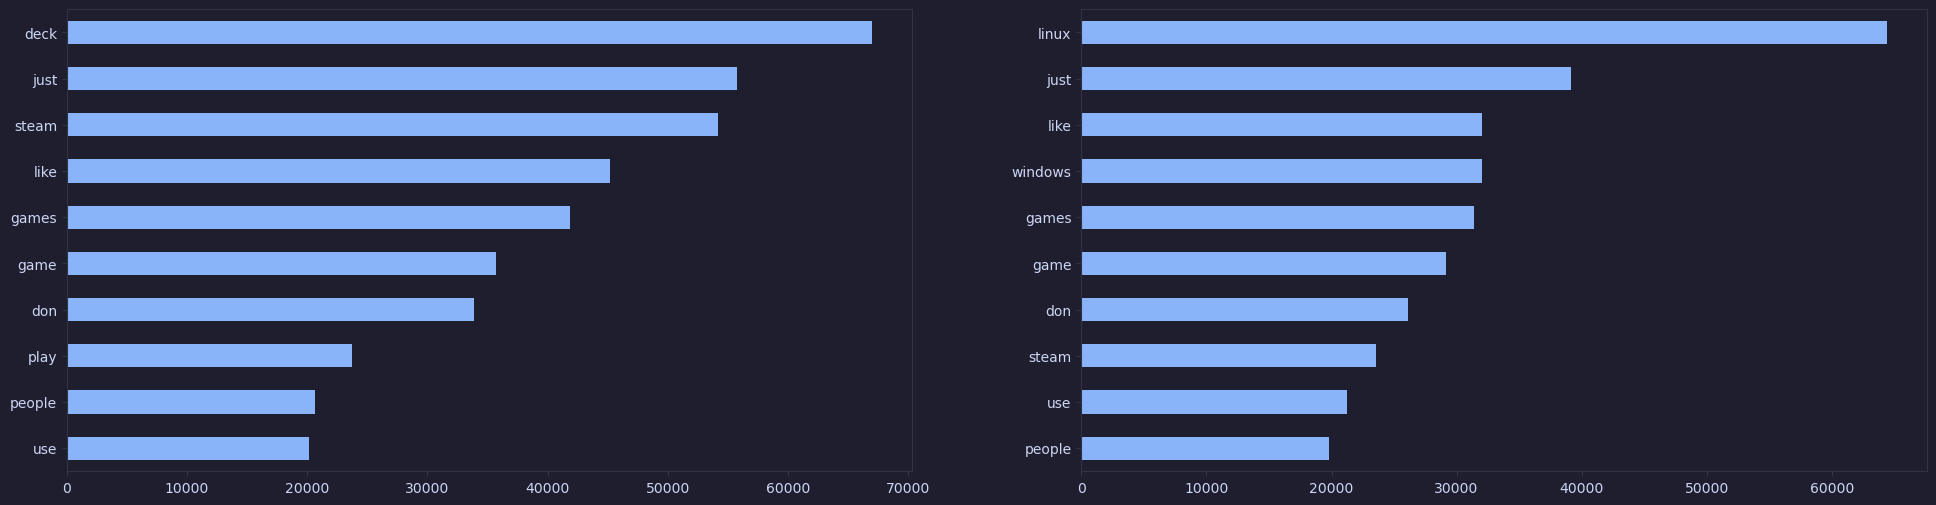

In [37]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

## Bigrams

In [38]:
cv = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=1000)

sd_titles_vect = cv.fit_transform(sd_titles['title'])
sd_titles_vect_df = pd.DataFrame(sd_titles_vect.todense(), columns=cv.get_feature_names_out())

lg_titles_vect = cv.fit_transform(lg_titles['title'])
lg_titles_vect_df = pd.DataFrame(lg_titles_vect.todense(), columns=cv.get_feature_names_out())

sd_comments_vect = cv.fit_transform(sd_comments['comments'])
sd_comments_vect_df = pd.DataFrame(sd_comments_vect.todense(), columns=cv.get_feature_names_out())

lg_comments_vect = cv.fit_transform(lg_comments['comments'])
lg_comments_vect_df = pd.DataFrame(lg_comments_vect.todense(), columns=cv.get_feature_names_out())

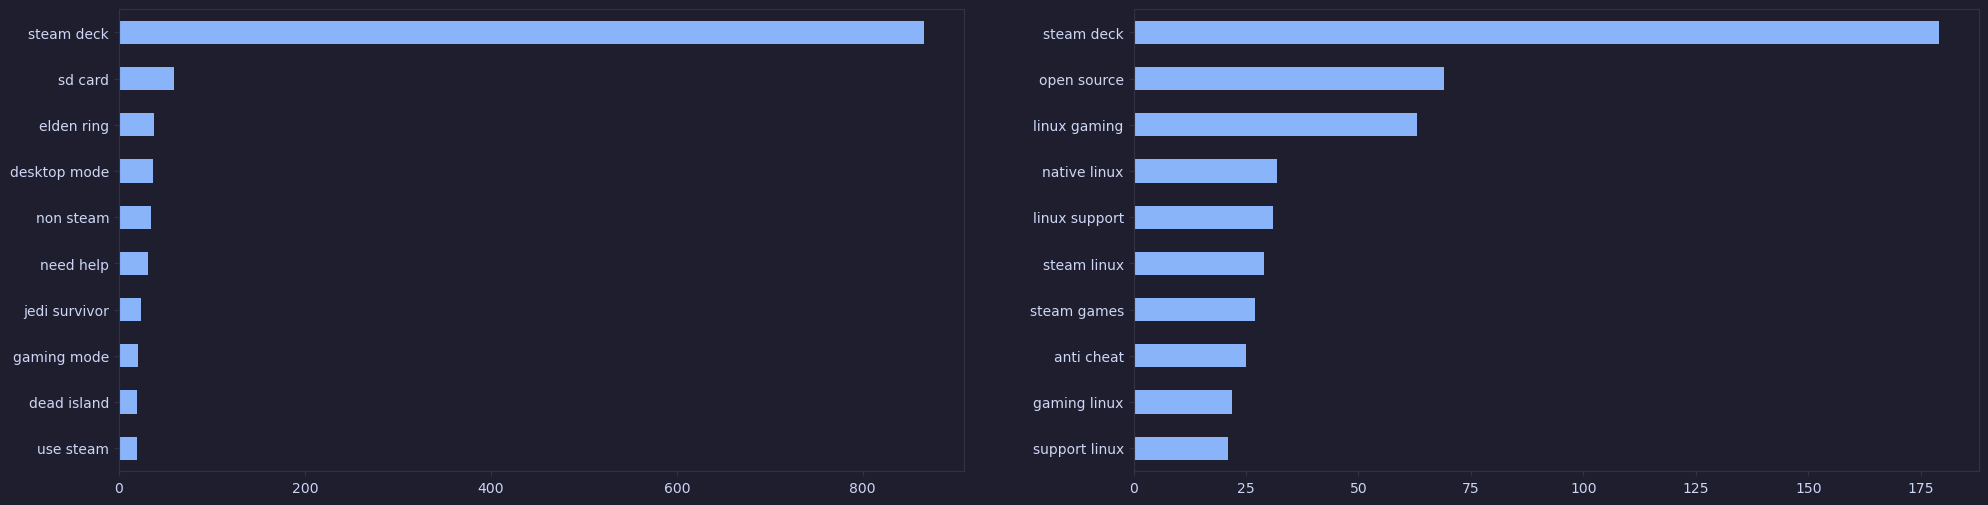

In [39]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

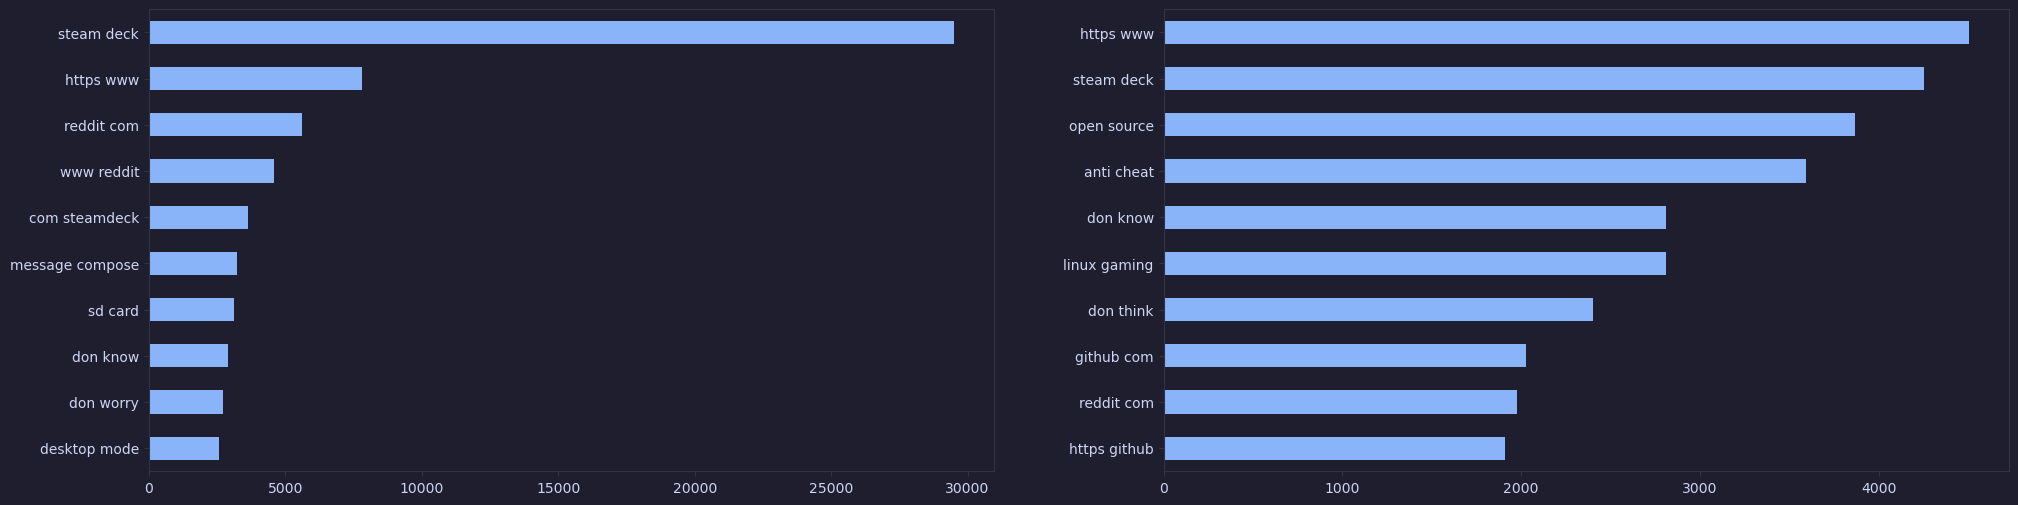

In [40]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

### Trigrams

In [41]:
cv = CountVectorizer(stop_words='english', ngram_range=(3,3), max_features=1000)

sd_titles_vect = cv.fit_transform(sd_titles['title'])
sd_titles_vect_df = pd.DataFrame(sd_titles_vect.todense(), columns=cv.get_feature_names_out())

lg_titles_vect = cv.fit_transform(lg_titles['title'])
lg_titles_vect_df = pd.DataFrame(lg_titles_vect.todense(), columns=cv.get_feature_names_out())

sd_comments_vect = cv.fit_transform(sd_comments['comments'])
sd_comments_vect_df = pd.DataFrame(sd_comments_vect.todense(), columns=cv.get_feature_names_out())

lg_comments_vect = cv.fit_transform(lg_comments['comments'])
lg_comments_vect_df = pd.DataFrame(lg_comments_vect.todense(), columns=cv.get_feature_names_out())

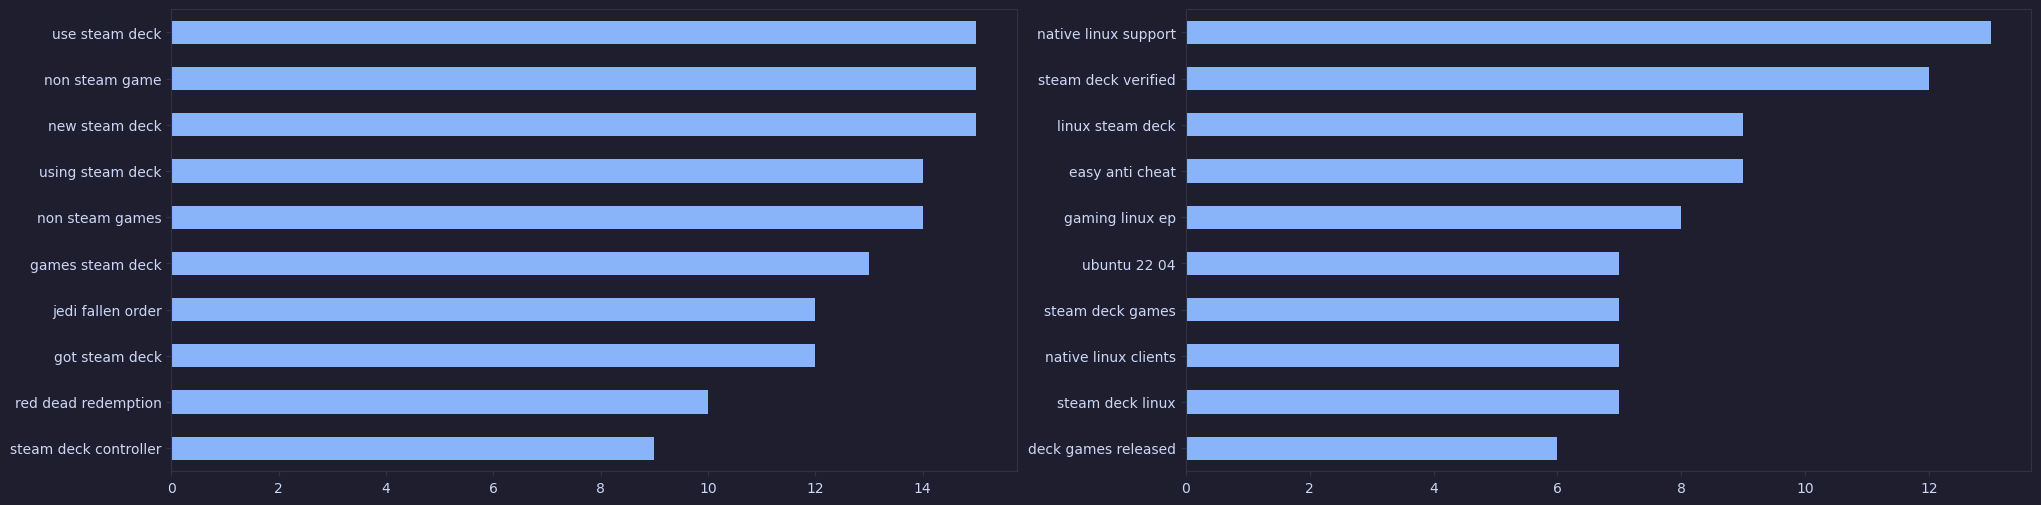

In [42]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_titles_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

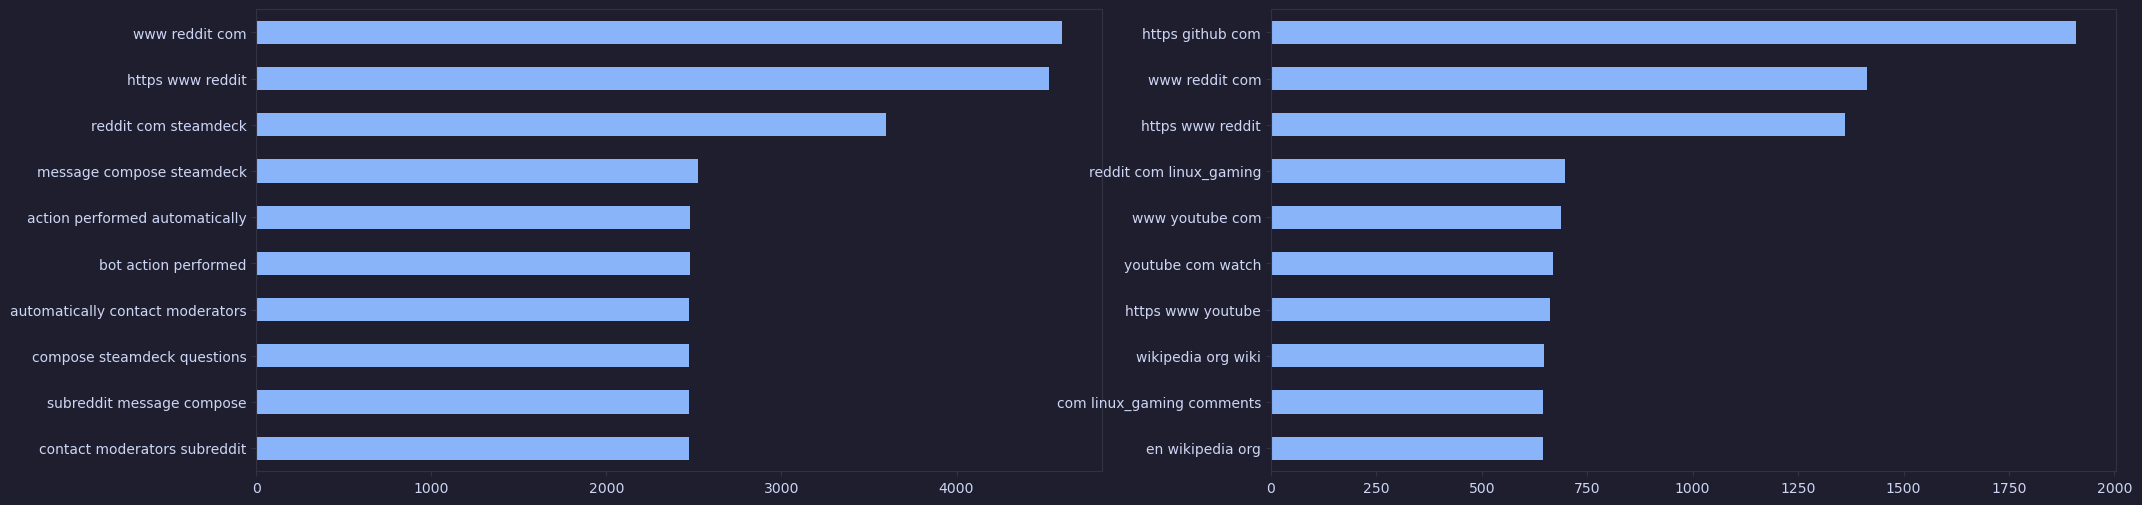

In [43]:
# Right Plot is r/SteamDeck and Left Plot is r/linux_gaming
fig, ax = plt.subplots(1, 2, figsize=(24,6))
sd_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
lg_comments_vect_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

Based on these lists we can begin to start to gain some insights on the poular topics on these subreddits. r/SteamDeck seems to a lot more community focused and will talk a lot about moderation, questions, or link to other reddit pages (most likely other posts withn there own subreddit. r/linux_gaming seems to be more techincally focused. The links shared a lot in the comments tend to be to public git repos or pages on wikipedia or youtube. There also seems to be talk about more specific parts of game software, like anti-cheat, and talk about operating systems.

## Sentiment Analysis

Finally let's do some basic sentament analysis on the subreddits. By doing this we can get a slight idea on a potential idea of positivity vs negativity on the subreddits. Reddit has a bit of a reputation for negativity at times, so it would be interesting to see what some sentiment analysis will show us.

In [44]:
sent = SentimentIntensityAnalyzer()

In [45]:
sent.polarity_scores(sd_comments['comments'][20])

{'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'compound': 0.8176}

Let's write some functions that will store the different sentiment analysis scores.

In [46]:
def get_title_sent_score(df):
    sent_scores_neg = []
    sent_scores_neu = []
    sent_scores_pos = []
    sent_scores_compound = []
    
    for index in df.index:
        sent_scores_neg.append(sent.polarity_scores(df['title'][index])['neg'])
        sent_scores_neu.append(sent.polarity_scores(df['title'][index])['neu'])
        sent_scores_pos.append(sent.polarity_scores(df['title'][index])['pos'])
        sent_scores_compound.append(sent.polarity_scores(df['title'][index])['compound'])
    
    df['negative_sentiment'] = sent_scores_neg
    df['neutral_sentiment'] = sent_scores_neu
    df['positive_sentiment'] = sent_scores_pos
    df['compund_sentiment'] = sent_scores_compound
    
    return

In [47]:
def get_comment_sent_score(df):
    sent_scores_neg = []
    sent_scores_neu = []
    sent_scores_pos = []
    sent_scores_compound = []
    
    for index in df.index:
        sent_scores_neg.append(sent.polarity_scores(df['comments'][index])['neg'])
        sent_scores_neu.append(sent.polarity_scores(df['comments'][index])['neu'])
        sent_scores_pos.append(sent.polarity_scores(df['comments'][index])['pos'])
        sent_scores_compound.append(sent.polarity_scores(df['comments'][index])['compound'])
    
    df['negative_sentiment'] = sent_scores_neg
    df['neutral_sentiment'] = sent_scores_neu
    df['positive_sentiment'] = sent_scores_pos
    df['compund_sentiment'] = sent_scores_compound
    
    return

In [48]:
get_title_sent_score(titles)

get_comment_sent_score(comments)

In [49]:
titles.head()

,title_id,title,subreddit,title_length,title_word_count,negative_sentiment,neutral_sentiment,positive_sentiment,compund_sentiment
0,pu1k55,epic games announce full easy anti cheat for linux including wine proton,linux_gaming,74,12,0.308,0.523,0.169,-0.3400
1,9pkgwj,the struggles of being a modern age linux gamer,linux_gaming,48,9,0.263,0.737,0.000,-0.3612
2,q8trki,steam has banned all games that utilise blockchain tech nfts or cryptocurrencies from the platform,linux_gaming,100,15,0.176,0.824,0.000,-0.4588
3,ijat04,they didn't expect linux gaming in 2007,linux_gaming,39,7,0.000,1.000,0.000,0.0000
4,re13t3,ltt are planning to include linux compatibility in future hardware reviews,linux_gaming,74,11,0.000,1.000,0.000,0.0000


In [50]:
comments.head()

,comment_id,comments,subreddit,comment_length,comment_word_count,negative_sentiment,neutral_sentiment,positive_sentiment,compund_sentiment
0,jibfcl5,fun fact the steam deck logo is just a pokeball that isn t trying second fun fact everyone else here is wrong i m right third fun fact human blood works as an industrial lubricant,SteamDeck,190,33,0.077,0.675,0.247,0.7783
1,jib4baj,no it's not the logo you see on the memory maker is coming from the old camera knob they where used to crank the camera for to record the clip could be pulled up then turned and put back in vintage camera https thumbs dreamstime com z vintage super eight film camera white background 66847894 jpg editthe logo of steam comes from a vintage steam machine and the steam deck is a flywheel part that's also used in steam machines steam machine drive https i ytimg com vi ghscy8u_o_0 maxresdefault jpg look at the wheel center part edit 2my bad wrong description what the camera knob is used for corr...,SteamDeck,635,90,0.077,0.889,0.034,-0.5994
2,jibacht,glad this isn't getting the traction you hoped for,SteamDeck,50,9,0.000,0.556,0.444,0.6808
3,jib5m0m,can't tell if you actually thought it was,SteamDeck,41,8,0.000,1.000,0.000,0.0000
4,jib5qio,this was inspired by this because it looks like it come on guys not everything has to have a reference or a nod,SteamDeck,115,23,0.000,0.769,0.231,0.6908


In [51]:
### Remaking Filtered Dataframes

sd_titles = titles[titles['subreddit']=='SteamDeck'] 
sd_comments = comments[comments['subreddit']=='SteamDeck']
lg_titles = titles[titles['subreddit']=='linux_gaming']
lg_comments = comments[comments['subreddit']=='linux_gaming']

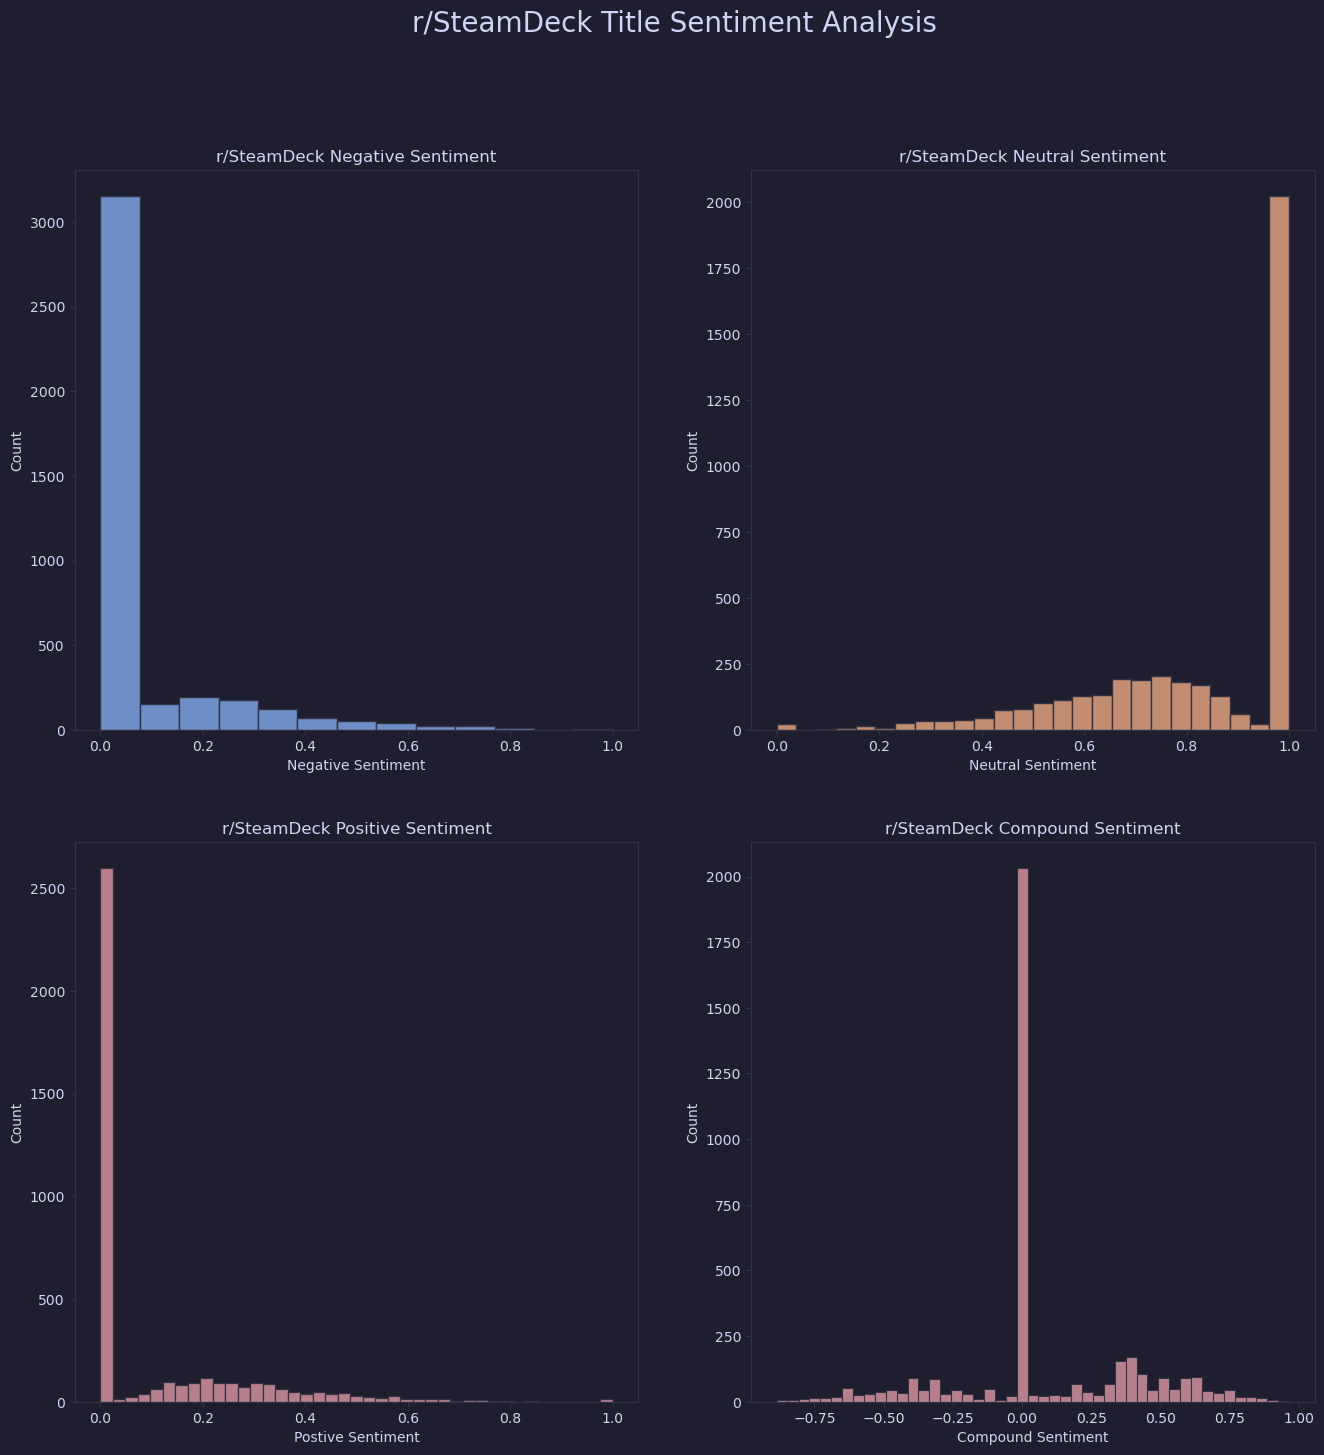

In [52]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

sns.histplot(sd_titles['negative_sentiment'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_titles['neutral_sentiment'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_titles['positive_sentiment'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_titles['compund_sentiment'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Negative Sentiment', title='r/SteamDeck Negative Sentiment')
ax[0,1].set(xlabel='Neutral Sentiment', title='r/SteamDeck Neutral Sentiment')
ax[1,0].set(xlabel='Postive Sentiment', title='r/SteamDeck Positive Sentiment')
ax[1,1].set(xlabel='Compound Sentiment', title='r/SteamDeck Compound Sentiment')

fig.suptitle('r/SteamDeck Title Sentiment Analysis', fontsize=20);

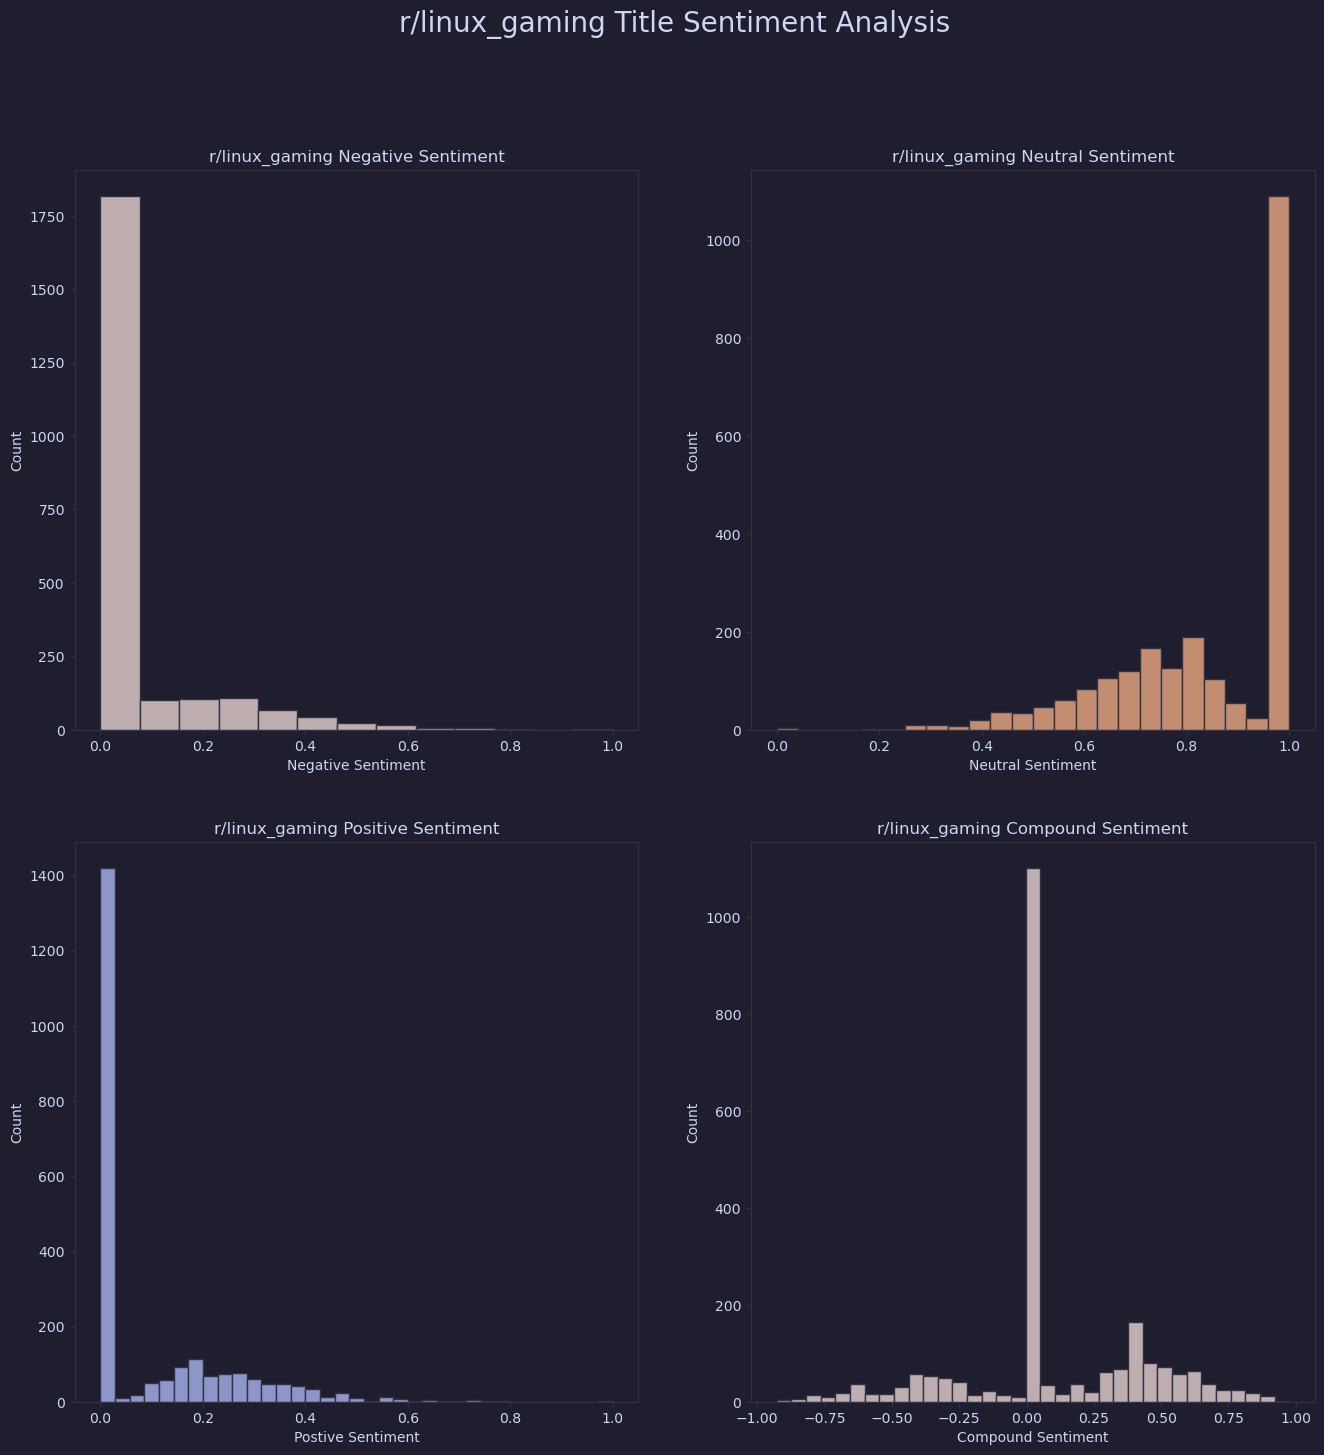

In [53]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

sns.histplot(lg_titles['negative_sentiment'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_titles['neutral_sentiment'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_titles['positive_sentiment'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_titles['compund_sentiment'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Negative Sentiment', title='r/linux_gaming Negative Sentiment')
ax[0,1].set(xlabel='Neutral Sentiment', title='r/linux_gaming Neutral Sentiment')
ax[1,0].set(xlabel='Postive Sentiment', title='r/linux_gaming Positive Sentiment')
ax[1,1].set(xlabel='Compound Sentiment', title='r/linux_gaming Compound Sentiment')

fig.suptitle('r/linux_gaming Title Sentiment Analysis', fontsize=20);

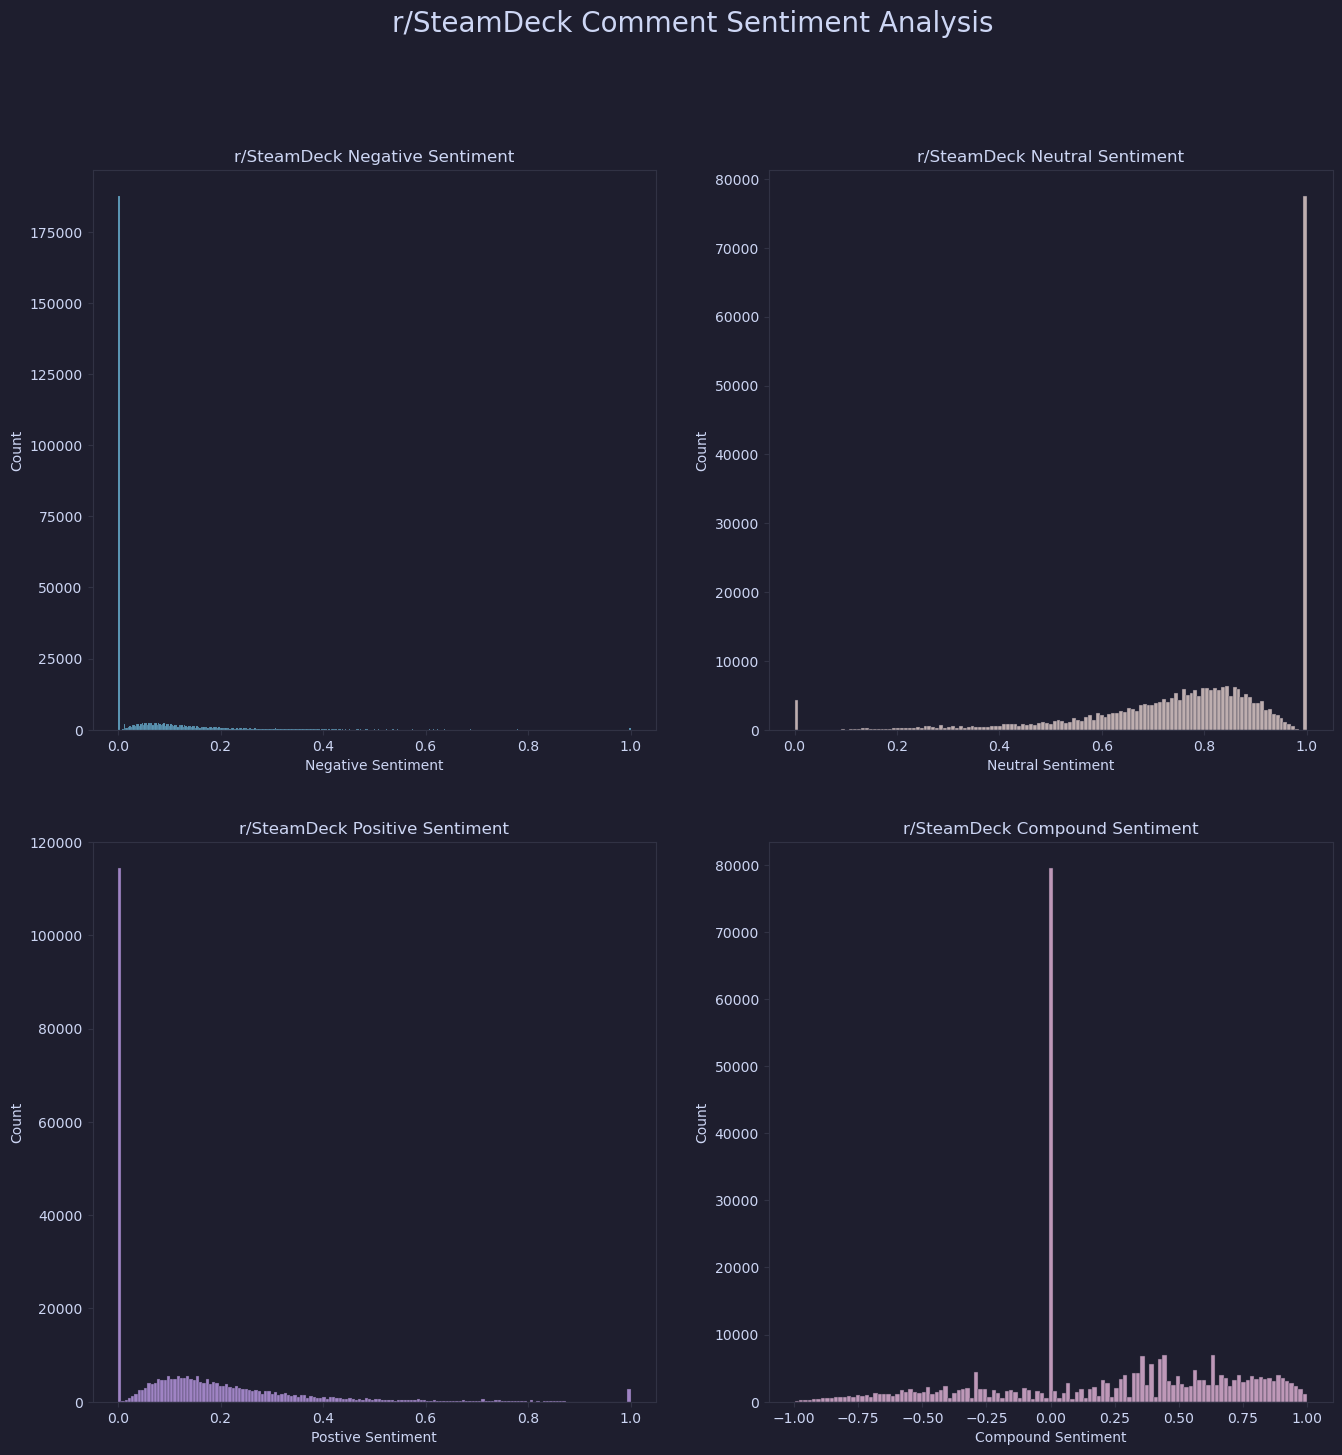

In [54]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

sns.histplot(sd_comments['negative_sentiment'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_comments['neutral_sentiment'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_comments['positive_sentiment'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(sd_comments['compund_sentiment'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Negative Sentiment', title='r/SteamDeck Negative Sentiment')
ax[0,1].set(xlabel='Neutral Sentiment', title='r/SteamDeck Neutral Sentiment')
ax[1,0].set(xlabel='Postive Sentiment', title='r/SteamDeck Positive Sentiment')
ax[1,1].set(xlabel='Compound Sentiment', title='r/SteamDeck Compound Sentiment')

fig.suptitle('r/SteamDeck Comment Sentiment Analysis', fontsize=20);

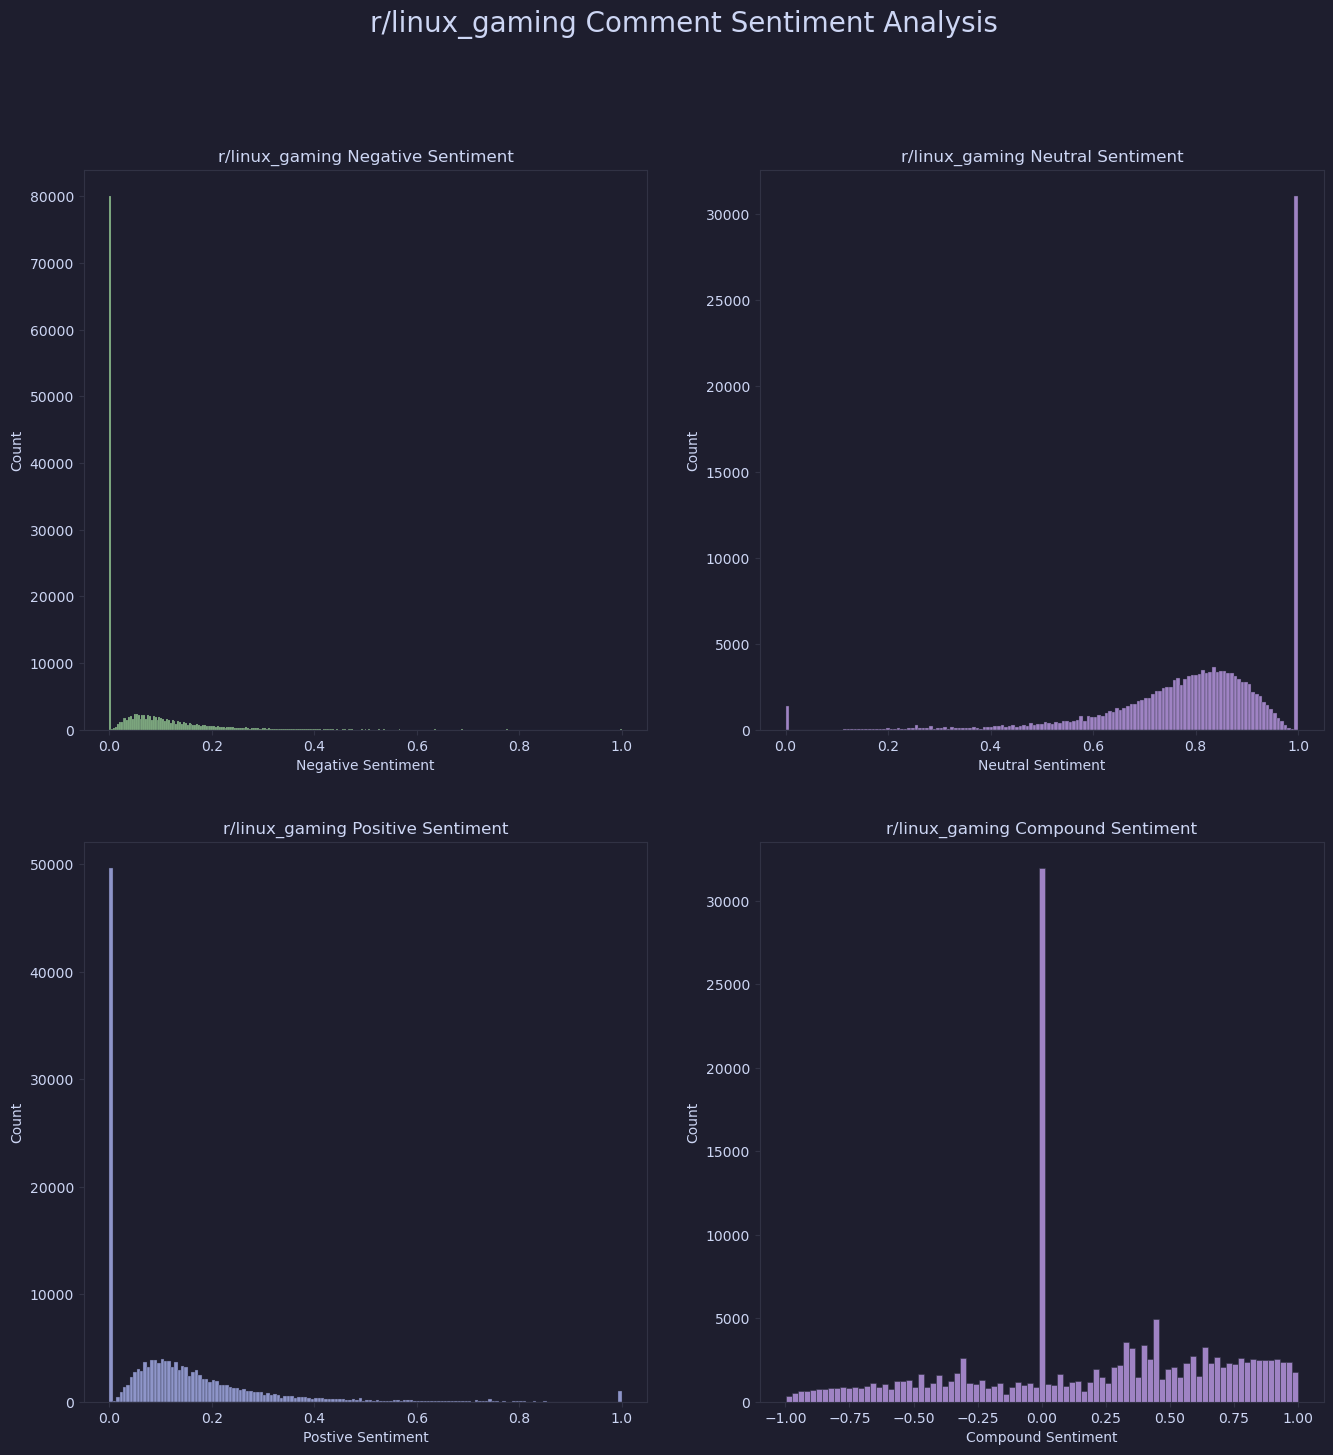

In [55]:
fig, ax =  plt.subplots(2, 2, figsize=(16,16))

sns.histplot(lg_comments['negative_sentiment'], ax=ax[0,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_comments['neutral_sentiment'], ax=ax[0,1],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_comments['positive_sentiment'], ax=ax[1,0],
             color=load_color("mocha", random.choice(cat_color)))

sns.histplot(lg_comments['compund_sentiment'], ax=ax[1,1],
             color=load_color("mocha", random.choice(cat_color)))

ax[0,0].set(xlabel='Negative Sentiment', title='r/linux_gaming Negative Sentiment')
ax[0,1].set(xlabel='Neutral Sentiment', title='r/linux_gaming Neutral Sentiment')
ax[1,0].set(xlabel='Postive Sentiment', title='r/linux_gaming Positive Sentiment')
ax[1,1].set(xlabel='Compound Sentiment', title='r/linux_gaming Compound Sentiment')

fig.suptitle('r/linux_gaming Comment Sentiment Analysis', fontsize=20);

Based on the histograms, it looks like when it comes to Title's of posts, there is very little detectable sentiment. However, when we look at comments, things get a bit more interesting. In general, it seem both sub reddits support more positive sentiment, than negative, however, that statement is much more true for r/SteamDeck than it is for r/linux_gaming. r/linux_gaming seems to have more noticeable amount of negative sentiment than r/SteamDeck.